## Bootstrap 

In [1]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import AutoProcessor, WhisperForAudioClassification, AutoConfig, PreTrainedModel, WhisperModel
from transformers import WhisperFeatureExtractor
from transformers import WhisperProcessor
import librosa
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F
from datasets import load_dataset, concatenate_datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import time
import random
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from dataclasses import dataclass
from typing import List, Dict, Union, List, Any

2025-06-16 13:14:59.152112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750079699.345876      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750079699.398975      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Для воспроизводимости

In [2]:
torch.set_float32_matmul_precision("high")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Uses device: {device}")

# кастомная архитектура классификатора на базе whisper енкодера
class WhisperClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels=5, dropout=0.2):
        super().__init__()
        self.pool_norm = nn.LayerNorm(hidden_size)
        self.pre_dropout = nn.Dropout(dropout)

        mid1 = max(hidden_size // 2, num_labels * 4)
        mid2 = max(hidden_size // 4, num_labels * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, mid1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid1),
            nn.Linear(mid1, mid2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(mid2),
            nn.Linear(mid2, num_labels),
        )

    def forward(self, hidden_states, attention_mask=None):
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1, keepdim=True)
            masked = hidden_states * attention_mask.unsqueeze(-1)
            pooled = masked.sum(dim=1) / lengths
        else:
            pooled = hidden_states.mean(dim=1)
        x = self.pool_norm(pooled)
        x = self.pre_dropout(x)
        logits = self.classifier(x)
        return logits

class WhisperForEmotionClassification(PreTrainedModel):
    config_class = AutoConfig

    def __init__(
        self, config, model_name="openai/whisper-small", num_labels=5, dropout=0.2
    ):
        super().__init__(config)
        self.encoder = WhisperModel.from_pretrained(model_name).encoder
        hidden_size = config.hidden_size
        self.classifier = WhisperClassifier(
            hidden_size, num_labels=num_labels, dropout=dropout
        )
        self.post_init()

    def forward(self, input_features, attention_mask=None, labels=None):
        encoder_output = self.encoder(
            input_features=input_features,
            attention_mask=attention_mask,
            return_dict=True,
        )
        hidden_states = encoder_output.last_hidden_state
        logits = self.classifier(hidden_states, attention_mask=attention_mask)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(
                logits.view(-1, logits.size(-1)), labels.view(-1)
            )
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )
        
model_name = "nixiieee/whisper-small-emotion-classifier-dusha"
processor = WhisperProcessor.from_pretrained("openai/whisper-small", return_attention_mask=True)
config = AutoConfig.from_pretrained(model_name)
model = WhisperForEmotionClassification.from_pretrained(model_name, num_labels=5, dropout=0.2).to(device)

Uses device: cuda


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Загружаем датасет

In [4]:
ds = load_dataset("nixiieee/dusha_balanced", split='test')

README.md:   0%|          | 0.00/912 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

val-00000-of-00002.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

val-00001-of-00002.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

test-00000-of-00002.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

test-00001-of-00002.parquet:   0%|          | 0.00/252M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36868 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/3600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3601 [00:00<?, ? examples/s]

Коллакатор и предобработка данных

In [5]:
@dataclass
class DataCollatorForEncoderClassification:
    processor: Any
    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_features = [
            {"input_features": feature["input_features"]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt"
        )

        batch["labels"] = torch.tensor(
            [feature["labels"] for feature in features], dtype=torch.long
        )

        return batch


def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = processor(
        audio["array"], sampling_rate=audio["sampling_rate"]
    ).input_features[0]
    batch["labels"] = batch["emotion"]
    return batch


test_ds = ds.map(
    prepare_dataset, remove_columns=["audio", "emotion"]
)

data_collator = DataCollatorForEncoderClassification(processor)

Map:   0%|          | 0/3601 [00:00<?, ? examples/s]

Формируем даталоадер

In [6]:
test_loader = DataLoader(
    test_ds,
    batch_size=1, # для теста на одном семпле
    shuffle=False,
    collate_fn=data_collator
)

In [7]:
model.to(device)
model.eval() # оцениваем качество на валидации

WhisperForEmotionClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementw

In [8]:
def get_predictions(model, data_loader):
    """
    Функция получения предсказаний модели
    """
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for x_batch in tqdm(data_loader, desc="Processing all batches"):
            batch = {k: v.to(device) for k, v in x_batch.items()}
            labels = batch['labels'].cpu().numpy()  # True labels for the batch
            all_labels.append(labels)
            outputs = model(input_features=batch['input_features'])
            logits = outputs.logits
            y_pred = F.softmax(logits, dim=1)
            label_pred = torch.argmax(y_pred, dim=-1)
            all_preds.append(label_pred.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    return all_labels, all_preds

In [9]:
# получаем предсказания
all_labels, all_preds = get_predictions(model, test_loader)

Processing all batches:   0%|          | 0/3601 [00:00<?, ?it/s]

In [51]:
def bootstrap_acc(all_labels, all_preds, iteration_list=[1000, 2000, 3000]):
    original_acc = accuracy_score(all_labels, all_preds)
    n_size = len(all_labels)
    
    # Shades of blue for different iteration counts
    colors = ['lightblue', 'skyblue', 'navy']
    ci_colors = ['lightblue', 'skyblue', 'navy']  # Colors for CI lines
    plt.figure(figsize=(12, 6))
    
    for idx, n_iterations in enumerate(iteration_list):
        acc_scores = []
        
        # Perform bootstrap sampling
        for i in range(n_iterations):
            indices = np.random.choice(n_size, size=n_size, replace=True)
            bootstrap_labels = all_labels[indices]
            bootstrap_preds = all_preds[indices]
            acc = accuracy_score(bootstrap_labels, bootstrap_preds)
            acc_scores.append(acc)
        mean_acc = np.mean(acc_scores)
        
        # Calculate 95% confidence intervals
        lower_ci, upper_ci = np.percentile(acc_scores, [2.5, 97.5])
        
        # Print results for this iteration count
        print(f"\nResults for {n_iterations} iterations:")
        print(f"Mean Accuracy Score: {mean_acc:.4f}")
        print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")
        
        # Plot histogram for this iteration count
        plt.hist(acc_scores, bins=30, alpha=0.3, color=colors[idx], 
                 label=f'{n_iterations} iterations', edgecolor='black')
        
        # Add confidence interval lines
        plt.axvline(lower_ci, color=ci_colors[idx], linestyle='--', 
                    label=f'CI {n_iterations}: [{lower_ci:.4f}, {upper_ci:.4f}]')
        plt.axvline(upper_ci, color=ci_colors[idx], linestyle='--')

        plt.axvline(mean_acc, color=ci_colors[idx], linestyle='-')        
    
    # Add vertical line for original accuracy
    plt.axvline(original_acc, color='blue', linestyle='-', 
                label=f'Original Accuracy: {original_acc:.4f}')
    
    # Customize plot
    plt.title('Bootstrap Distribution of Accuracy Scores for Different Iterations')
    plt.xlabel('Accuracy Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.8)
    plt.tight_layout()
    plt.show()


Results for 1000 iterations:
Mean Accuracy Score: 0.7472
95% Confidence Interval: [0.7337, 0.7609]

Results for 2000 iterations:
Mean Accuracy Score: 0.7474
95% Confidence Interval: [0.7329, 0.7615]

Results for 3000 iterations:
Mean Accuracy Score: 0.7473
95% Confidence Interval: [0.7328, 0.7615]


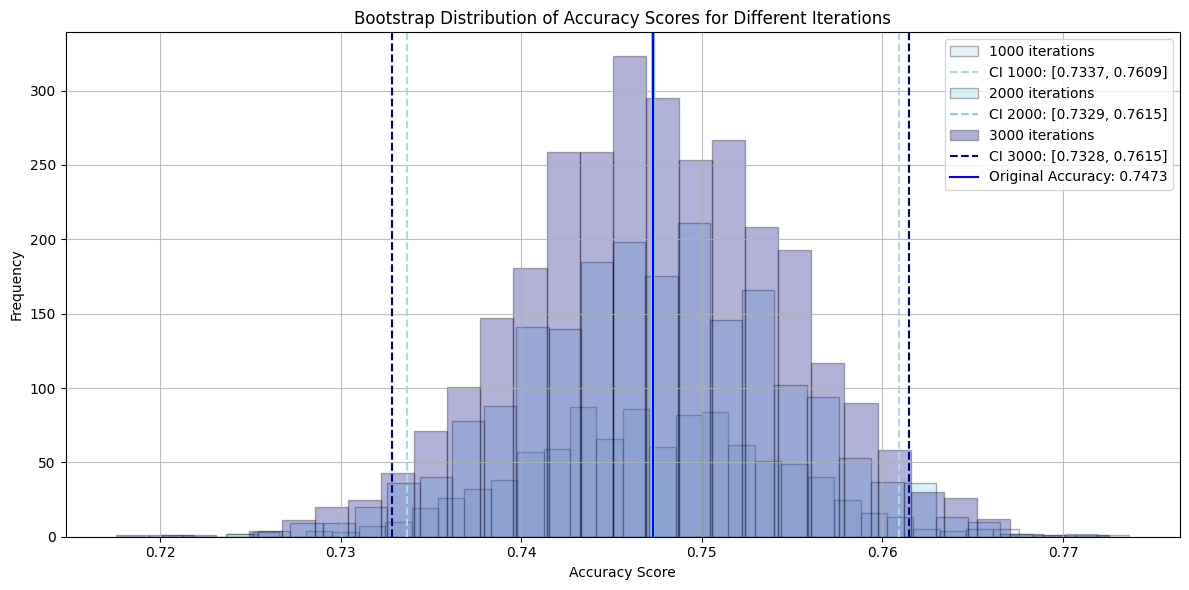

In [53]:
bootstrap_acc(all_labels, all_preds)

In [55]:
def bootstrap_f1(all_labels, all_preds, iteration_list=[1000, 2000, 3000]):
    original_f1 = f1_score(all_labels, all_preds, average="macro")
    n_size = len(all_labels)
    
    # Shades of blue for different iteration counts
    colors = ['lightblue', 'skyblue', 'navy']
    ci_colors = ['lightblue', 'skyblue', 'navy']  # Colors for CI lines
    plt.figure(figsize=(12, 6))
    
    for idx, n_iterations in enumerate(iteration_list):
        f1_scores = []
        
        # Perform bootstrap sampling
        for i in range(n_iterations):
            indices = np.random.choice(n_size, size=n_size, replace=True)
            bootstrap_labels = all_labels[indices]
            bootstrap_preds = all_preds[indices]
            f1 = f1_score(bootstrap_labels, bootstrap_preds, average="macro")
            f1_scores.append(f1)

        mean_f1 = np.mean(f1_scores)
        # Calculate 95% confidence intervals
        lower_ci, upper_ci = np.percentile(f1_scores, [2.5, 97.5])
        
        # Print results for this iteration count
        print(f"\nResults for {n_iterations} iterations:")
        print(f"Mean F1 Score: {mean_f1:.4f}")
        print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")
        
        # Plot histogram for this iteration count
        plt.hist(f1_scores, bins=30, alpha=0.3, color=colors[idx], 
                 label=f'{n_iterations} iterations', edgecolor='black')
        
        # Add confidence interval lines
        plt.axvline(lower_ci, color=ci_colors[idx], linestyle='--', 
                    label=f'CI {n_iterations}: [{lower_ci:.4f}, {upper_ci:.4f}]')
        plt.axvline(upper_ci, color=ci_colors[idx], linestyle='--')
    
    # Add vertical line for original accuracy
    plt.axvline(original_f1, color='blue', linestyle='-', 
                label=f'Original F1: {original_f1:.4f}')
    
    # Customize plot
    plt.title('Bootstrap Distribution of F1 Scores for Different Iterations')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.8)
    plt.tight_layout()
    plt.show()

# Example usage (assuming all_labels and all_preds are defined):
# bootstrap(all_labels, all_preds, iteration_list=[100, 1000, 10000])


Results for 1000 iterations:
Mean F1 Score: 0.7797
95% Confidence Interval: [0.7648, 0.7937]

Results for 2000 iterations:
Mean F1 Score: 0.7792
95% Confidence Interval: [0.7640, 0.7939]

Results for 3000 iterations:
Mean F1 Score: 0.7793
95% Confidence Interval: [0.7645, 0.7933]


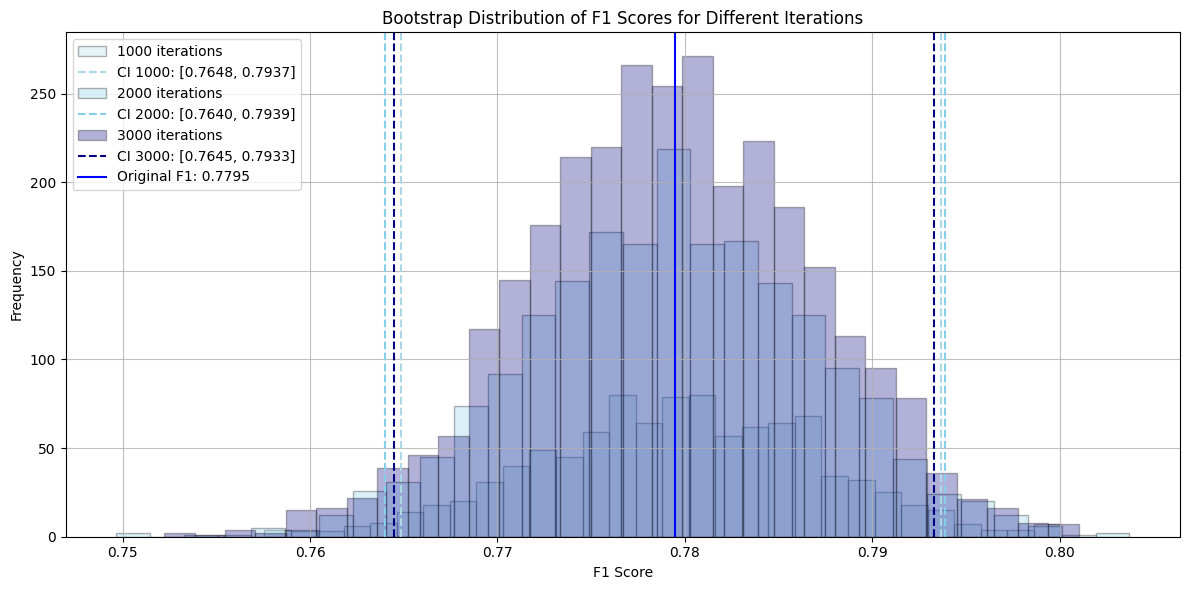

In [56]:
bootstrap_f1(all_labels, all_preds)